<a href="https://colab.research.google.com/github/ZeyzilanKrkmz/ZeyzilanKrkmz/blob/main/CokluDuyguAnaliziveTahmibSist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Veri setini simüle etme
np.random.seed(42)

# Sosyal medya ve müzik verilerini içeren sentetik veri seti oluşturma
def generate_synthetic_data(num_samples=1000):
    # Duygu etiketleri
    emotions = ['mutlu', 'üzgün', 'endişeli', 'sakin', 'heyecanlı']

    # Sentetik veri oluşturma
    data = {
        'metin_uzunluk': np.random.randint(10, 200, num_samples),
        'muzik_turu': np.random.choice(['pop', 'rock', 'klasik', 'jazz', 'elektronik'], num_samples),
        'dinlenme_suresi': np.random.randint(1, 240, num_samples),
        'paylasim_zamani': pd.date_range(start='2023-01-01', periods=num_samples),
        'duygu': np.random.choice(emotions, num_samples)
    }

    df = pd.DataFrame(data)
    return df

# Veri setini oluşturma
df = generate_synthetic_data()
print(df.head())
print("\nVeri Seti İstatistikleri:")
print(df.describe())

# Kategorik değişkenlerin kodlanması
le_muzik = LabelEncoder()
le_duygu = LabelEncoder()

df['muzik_turu_encoded'] = le_muzik.fit_transform(df['muzik_turu'])
df['duygu_encoded'] = le_duygu.fit_transform(df['duygu'])

# Özellik mühendisliği
df['metin_uzunluk_norm'] = StandardScaler().fit_transform(df['metin_uzunluk'].values.reshape(-1, 1))
df['dinlenme_suresi_norm'] = StandardScaler().fit_transform(df['dinlenme_suresi'].values.reshape(-1, 1))

   metin_uzunluk muzik_turu  dinlenme_suresi paylasim_zamani      duygu
0            112        pop              203      2023-01-01      üzgün
1            189       rock               68      2023-01-02      mutlu
2            102     klasik               98      2023-01-03  heyecanlı
3             24       rock              125      2023-01-04      sakin
4            116     klasik              102      2023-01-05      mutlu

Veri Seti İstatistikleri:
       metin_uzunluk  dinlenme_suresi      paylasim_zamani
count    1000.000000      1000.000000                 1000
mean      105.994000       120.796000  2024-05-14 12:00:00
min        10.000000         2.000000  2023-01-01 00:00:00
25%        59.000000        60.750000  2023-09-07 18:00:00
50%       108.000000       124.000000  2024-05-14 12:00:00
75%       153.250000       176.250000  2025-01-19 06:00:00
max       199.000000       239.000000  2025-09-26 00:00:00
std        55.093241        68.703672                  NaN


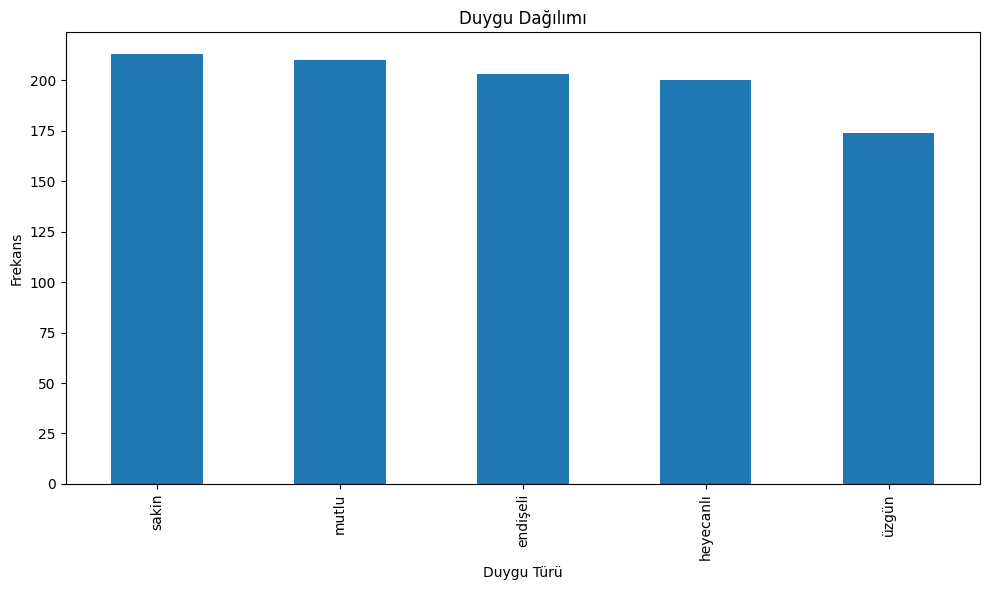

<Figure size 1200x600 with 0 Axes>

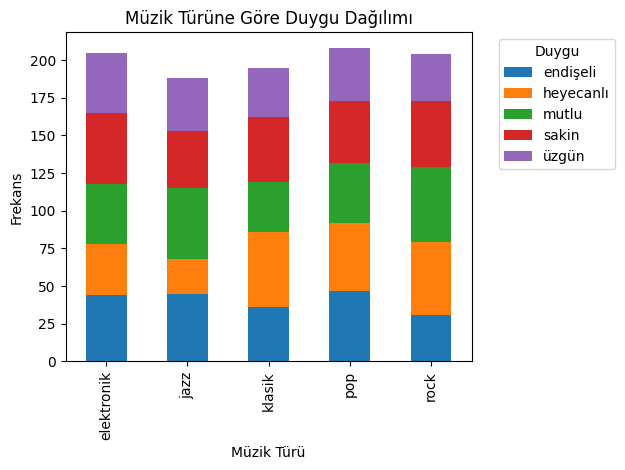

In [2]:
# Duygu Dağılımı Görselleştirmesi
plt.figure(figsize=(10, 6))
df['duygu'].value_counts().plot(kind='bar')
plt.title('Duygu Dağılımı')
plt.xlabel('Duygu Türü')
plt.ylabel('Frekans')
plt.tight_layout()
plt.show()

# Müzik Türü ve Duygu İlişkisi
plt.figure(figsize=(12, 6))
df.groupby(['muzik_turu', 'duygu']).size().unstack().plot(kind='bar', stacked=True)
plt.title('Müzik Türüne Göre Duygu Dağılımı')
plt.xlabel('Müzik Türü')
plt.ylabel('Frekans')
plt.legend(title='Duygu', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1833 - loss: 1.6188  

Test Accuracy: 18.00%
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Sınıflandırma Raporu:
              precision    recall  f1-score   support

    endişeli       0.07      0.03      0.04        34
   heyecanlı       0.20      0.44      0.28        39
       mutlu       0.12      0.02      0.03        53
       sakin       0.20      0.37      0.26        43
       üzgün       0.07      0.03      0.04        31

    accuracy                           0.18       200
   macro avg       0.13      0.18      0.13       200
weighted avg       0.14      0.18      0.13       200



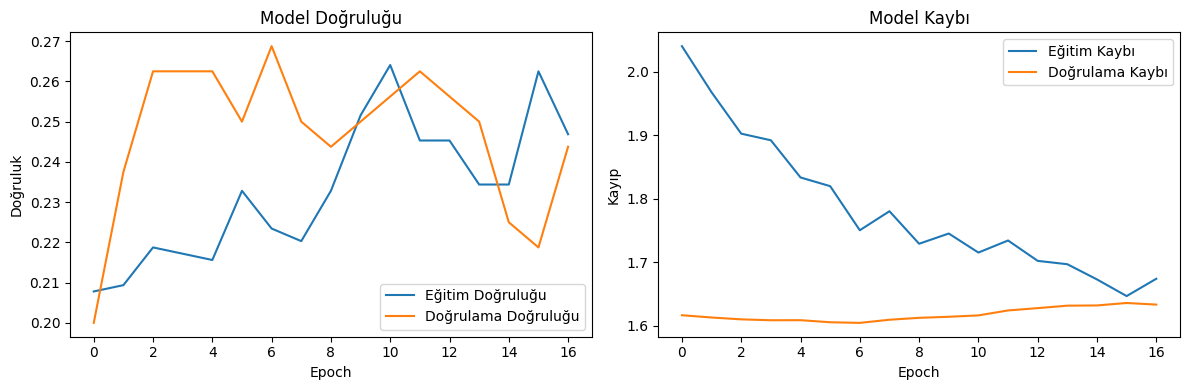

In [3]:
# Veriyi hazırlama
X = df[['metin_uzunluk_norm', 'muzik_turu_encoded', 'dinlenme_suresi_norm']].values
y = df['duygu_encoded'].values

# Eğitim ve test setlerini ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modeli oluşturma
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(3,)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(len(np.unique(y)), activation='softmax')
])

# Modeli derleme
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Erken durdurma
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Modeli eğitme
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=0
)

# Model performansını değerlendirme
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_accuracy*100:.2f}%")

# Tahminleme
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Sınıflandırma raporu
print("\nSınıflandırma Raporu:")
print(classification_report(
    y_test,
    y_pred_classes,
    target_names=le_duygu.classes_
))

# Eğitim performansını görselleştirme
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Model Doğruluğu')
plt.ylabel('Doğruluk')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kaybı')
plt.ylabel('Kayıp')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

In [4]:
# Zaman serisi için ekstra fonksiyon
def gelecek_duygu_tahmini(model, son_veriler, gun_sayisi=7):
    tahminler = []
    current_data = son_veriler

    for _ in range(gun_sayisi):
        tahmin = model.predict(current_data.reshape(1, -1))
        tahmin_sinifi = np.argmax(tahmin)
        tahminler.append(le_duygu.inverse_transform([tahmin_sinifi])[0])

        # Basit bir veri güncelleme mekanizması
        current_data[0] += np.random.normal(0, 0.1)
        current_data[1] = np.random.randint(0, 5)
        current_data[2] += np.random.normal(0, 0.2)

    return tahminler

# Son verileri kullanarak gelecek tahminleri alma
son_veriler = X_test[0]
gelecek_tahminleri = gelecek_duygu_tahmini(model, son_veriler)
print("\nGelecek 7 Günlük Duygu Tahmini:")
print(gelecek_tahminleri)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

Gelecek 7 Günlük Duygu Tahmini:
['sakin', 'sakin', 'endişeli', 'heyecanlı', 'sakin', 'sakin', 'sakin']
